In [28]:
import sqlite3

import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import seaborn.objects as so
from sklearn.preprocessing import StandardScaler

sns.set_style("darkgrid")
float_formatter = "{:.5}".format
np.set_printoptions(formatter={"float_kind": float_formatter})
random_state = 42

In [29]:
def dict_factory(cursor, row):
    col_names = [col[0] for col in cursor.description]
    return {key: value for key, value in zip(col_names, row)}


query_white = """
    SELECT
        g.result,
        --g.start_time + 40 * g.increment as total_time,
        g.increment,
        g.start_time,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result == 1
        AND p.eval is not NULL
    """

query_black = """
    SELECT
        g.result,
        --g.start_time + 40 * g.increment as total_time,
        g.increment,
        g.start_time,
        g.url,
        p.eval,
        p.ply,
        g.elo_white - g.elo_black as elo_dif,
        1 as weight
    FROM
        games g INNER JOIN positions p
        ON g.rowid = p.game_id
    WHERE
        g.result == -1
        AND p.eval is not NULL
    """



with sqlite3.connect("games.sqlite") as con:
    con.row_factory = dict_factory
    data_white = pd.DataFrame(con.execute(query_white))
    data_black = pd.DataFrame(con.execute(query_black))
con.close()

In [30]:
min_evals_white = -data_white.groupby("url").min()["eval"]
min_evals_black = data_black.groupby("url").max()["eval"]

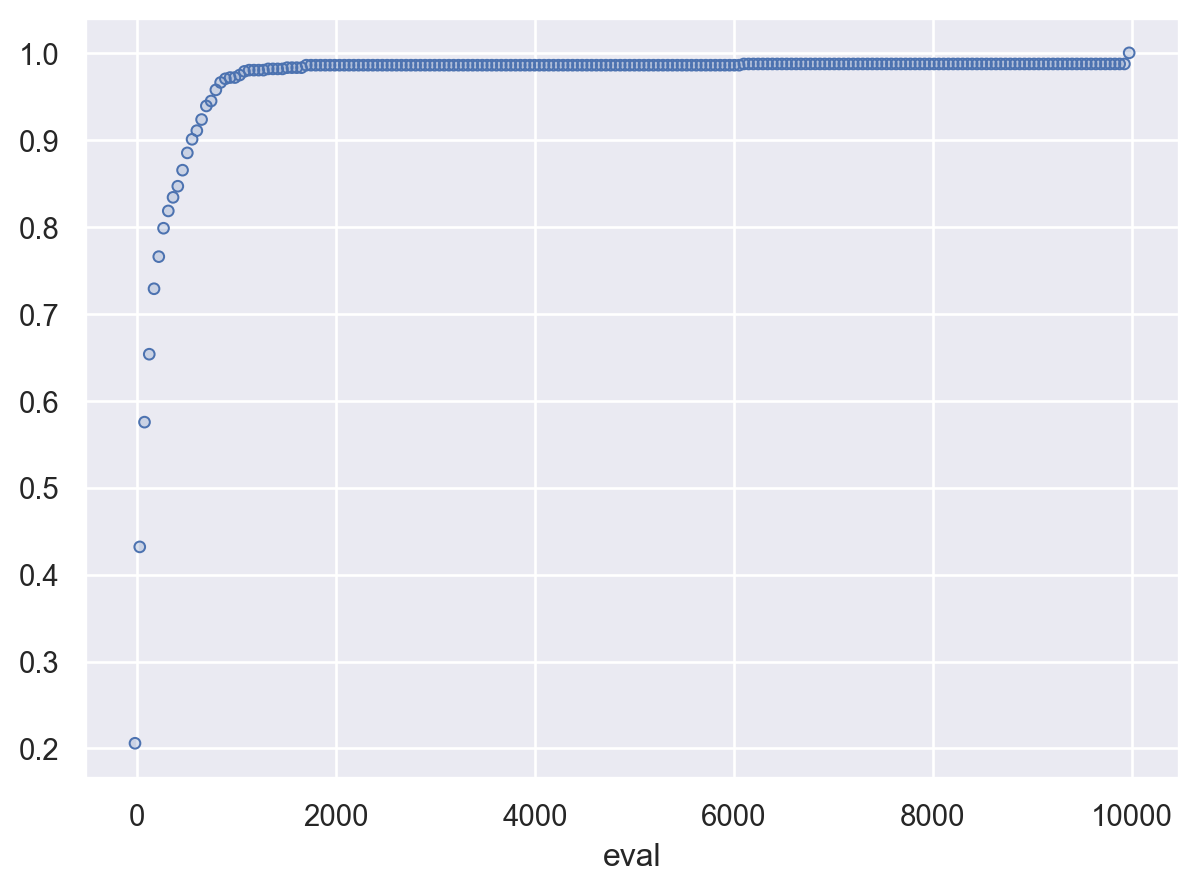

In [31]:
so.Plot(x=min_evals_white).add(so.Dots(), so.Hist(cumulative=True, stat="density"))
# so.Plot(x=min_evals_black).add(so.Dots(), so.Hist(cumulative=True, stat="density"))

In [32]:
hist1 = np.histogram(-min_evals_white, bins=1000)
hist2 = np.histogram(min_evals_black, bins=1000)

In [43]:
dist1 = scipy.stats.rv_histogram(hist1)
dist2 = scipy.stats.rv_histogram(hist2)

xs = np.arange(-1000, 1000, 0.1)


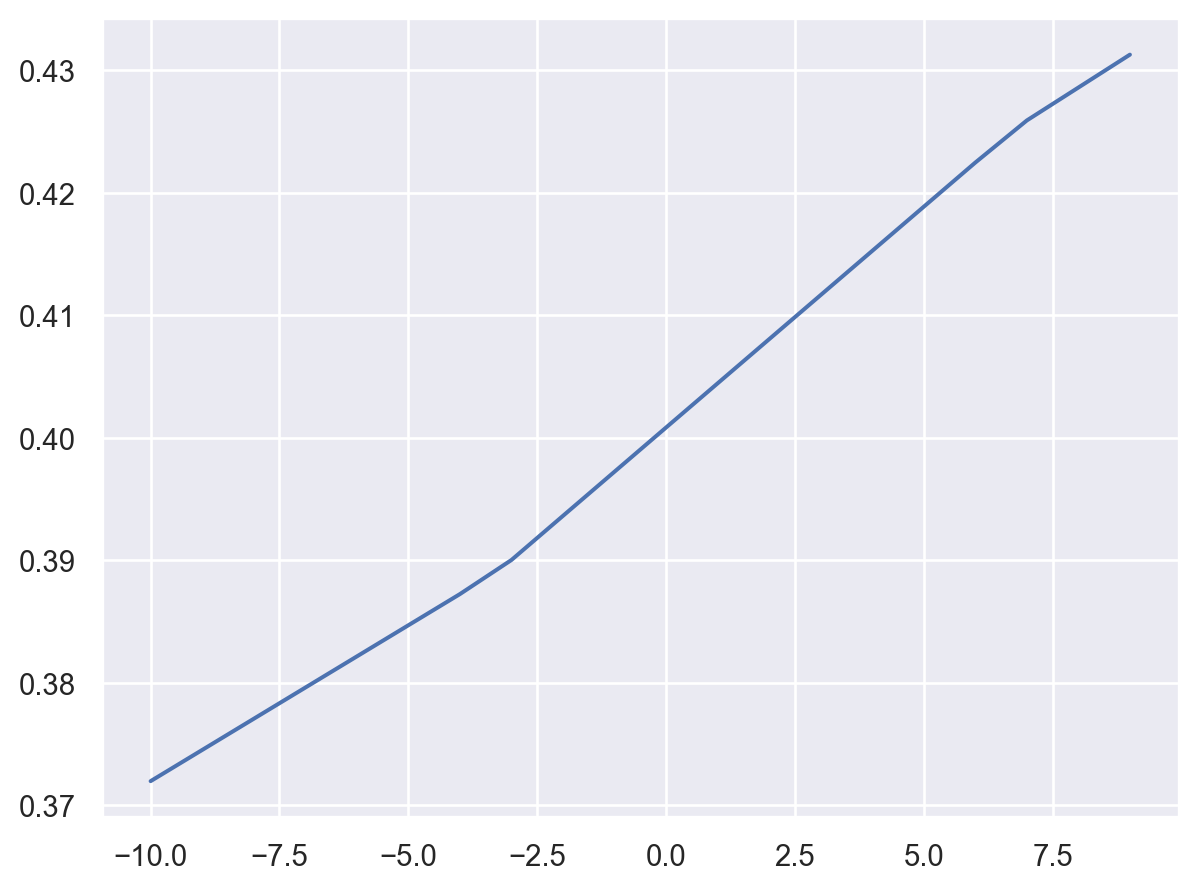

In [44]:
so.Plot(x=np.arange(-10, 10, 1), y=dist1.cdf(np.arange(-10, 10, 1))*0.5).add(
    so.Line(),
)

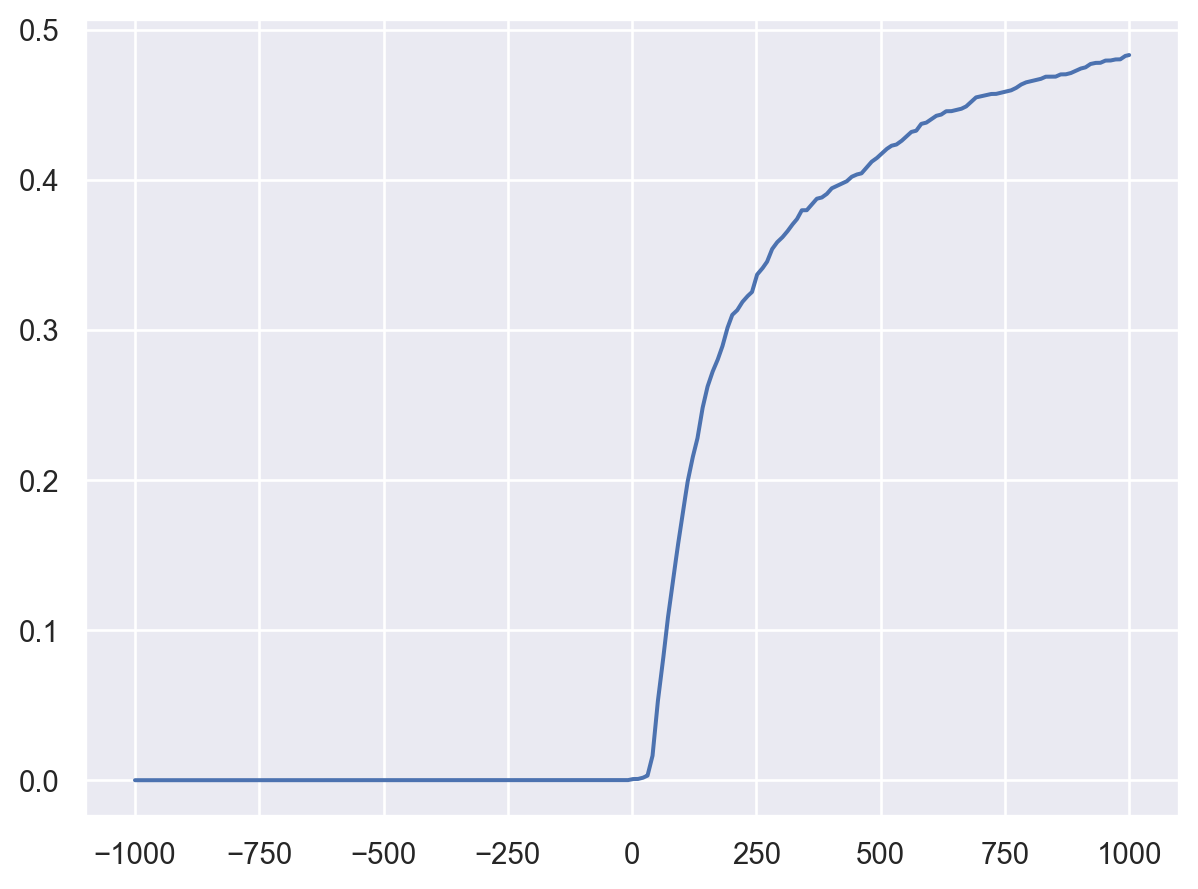

In [55]:
so.Plot(x=xs, y=dist2.cdf(xs)*0.5).add(
    so.Line(),
)

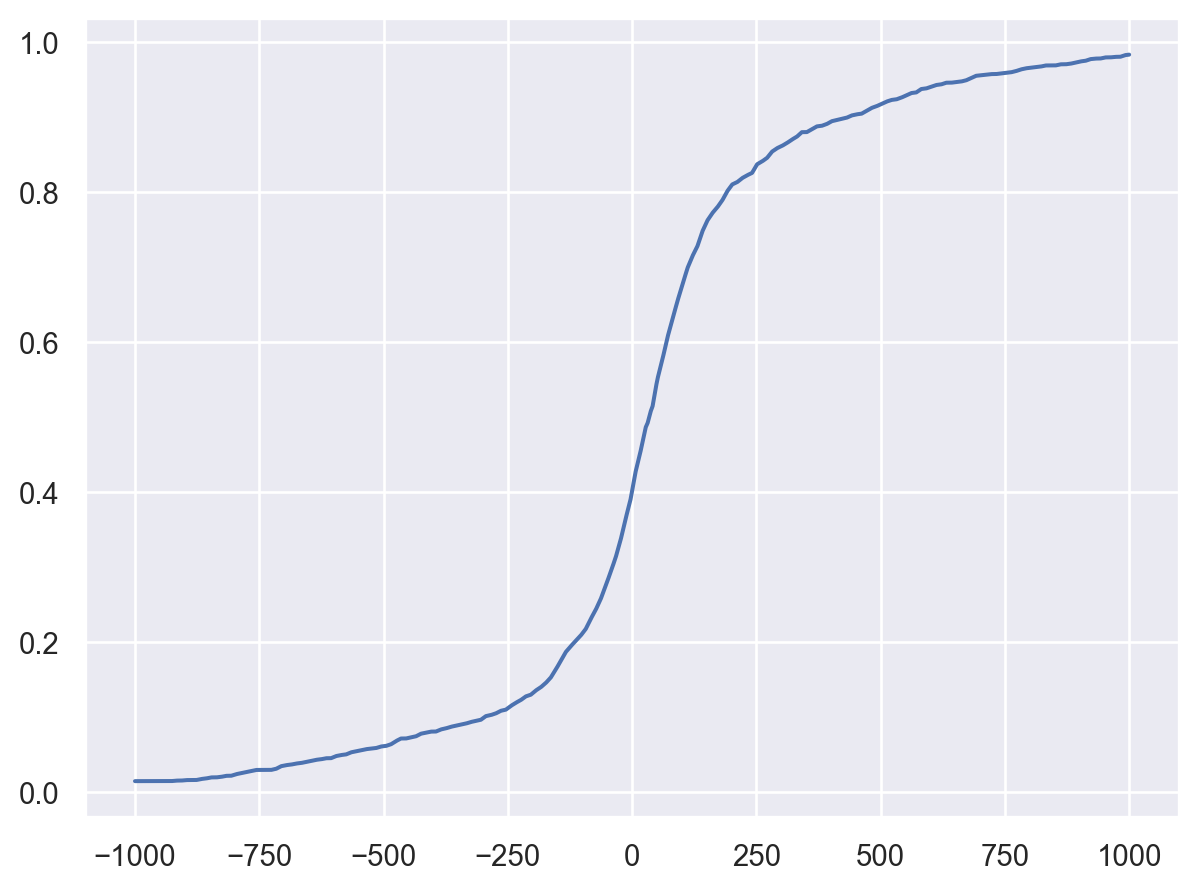

In [46]:
so.Plot(x=xs, y=(dist1.cdf(xs) + dist2.cdf(xs)) * 0.5).add(
    so.Line(),
)

In [51]:
def win_proba(cp, a):
    return 50 + 50 * (2/(1+np.exp(-a * cp))-1)

In [52]:
from scipy.optimize import curve_fit

curve_fit(win_proba, xdata=xs, ydata=(dist1.cdf(xs) + dist2.cdf(xs)) * 0.5 )

C:\Users\smartens\AppData\Local\Temp\ipykernel_3324\2196986406.py:2: RuntimeWarning: overflow encountered in exp
  return 50 + 50 * (2/(1+np.exp(-a * cp))-1)


(array([2.6889e-05]), array([[5.8872e-10]]))

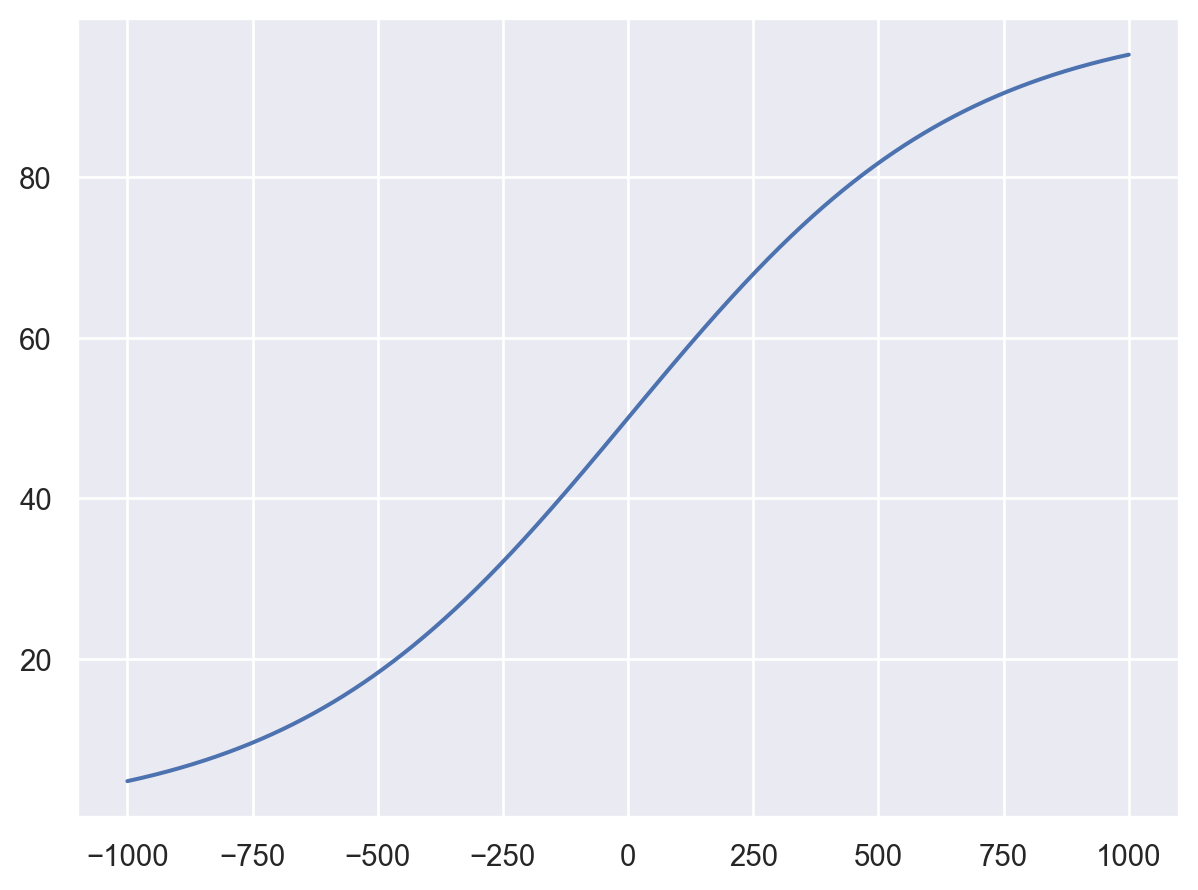

In [53]:

so.Plot(x=xs, y=win_proba(xs, 0.003)) .add(
    so.Line(),
)

In [54]:
win_proba(0.003, 50)

53.74298453437496